In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Embedding, Dropout, add,
    MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Layer
)

2025-05-08 13:44:38.720453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746711878.960391      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746711879.021118      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Base directory for the Flickr8k dataset
BASE_DIR = '/kaggle/input/flicker8k'
WORKING_DIR = '/kaggle/working'

In [3]:
# Load pretrained DenseNet201 without the top classification layer
base_model = DenseNet201(weights='imagenet', include_top=False, pooling='avg')
model_cnn = Model(inputs=base_model.input, outputs=base_model.output)

I0000 00:00:1746711955.106465      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746711955.107084      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Extract features from images
features = {}
directory = os.path.join(BASE_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model_cnn.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1746712030.750016      95 service.cc:148] XLA service 0x7c17ec0041c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746712030.750946      95 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746712030.750968      95 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746712032.858245      95 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746712045.232584      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
# Save features
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb') as f:
    pickle.dump(features, f)

In [6]:
# Load captions
captions_path = os.path.join(BASE_DIR, 'captions.txt')
with open(captions_path, 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
# Create mapping from image ID to captions
mapping = {}
for line in tqdm(captions_doc.strip().split('\n')):
    tokens = line.split(',')
    if len(tokens) < 2:
        continue
    image_id = tokens[0].split('.')[0]
    caption = " ".join(tokens[1:]).strip()
    mapping.setdefault(image_id, []).append(caption)

  0%|          | 0/40455 [00:00<?, ?it/s]

In [8]:
# Clean the captions
import re
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i].lower()
            caption = re.sub(r'[^a-z ]', '', caption)
            caption = re.sub(r'\s+', ' ', caption)
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption
clean(mapping)

In [9]:
# Tokenize the captions
all_captions = [cap for caps in mapping.values() for cap in caps]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)


In [10]:
# Split dataset
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.95)
train, test = image_ids[:split], image_ids[split:]

In [11]:
# Data generator for training
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key in data_keys:
            n += 1
            for caption in mapping[key]:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0
                gc.collect()


In [12]:
# Transformer Encoder Block
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([Dense(ff_dim, activation='relu'), Dense(embed_dim)])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

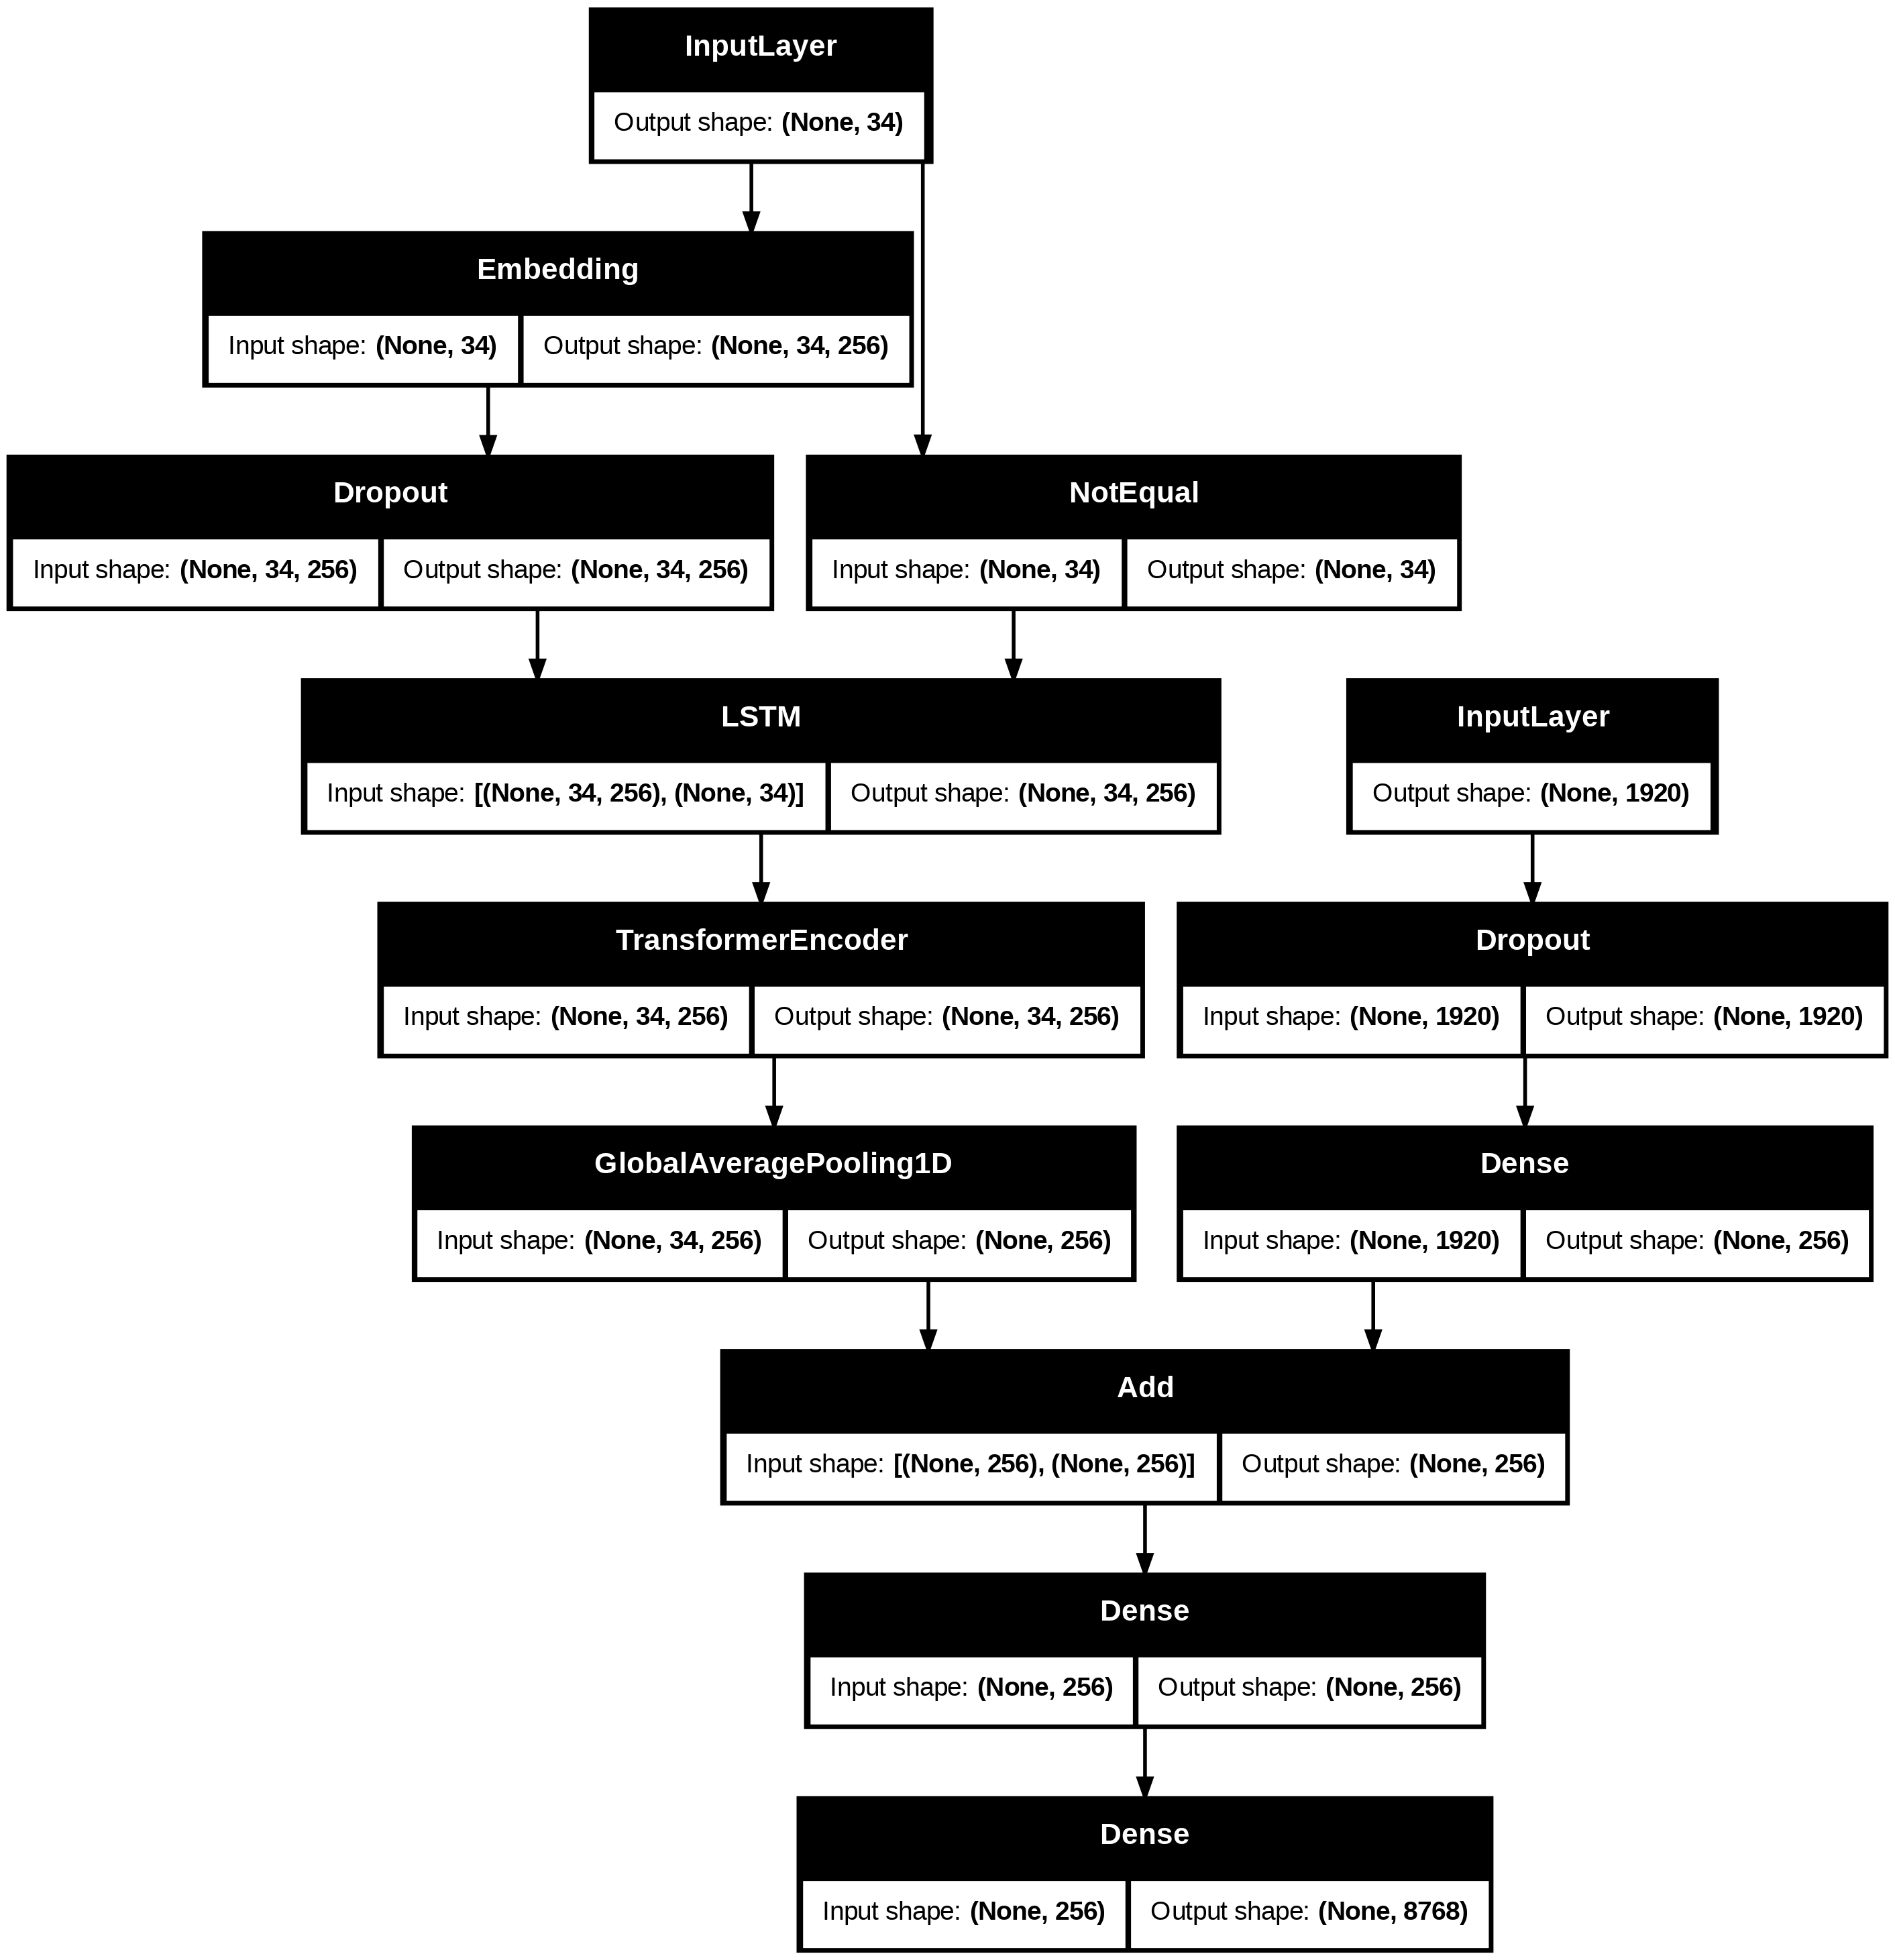

In [13]:
# Build the model
inputs1 = Input(shape=(1920,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
x = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
x = Dropout(0.4)(x)
x = LSTM(256, return_sequences=True)(x)
x = TransformerEncoder(embed_dim=256, num_heads=4, ff_dim=512)(x)
se3 = GlobalAveragePooling1D()(x)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model, show_shapes=True)


In [14]:
# Train the model
epochs = 30
batch_size = 32
steps = len(train) // batch_size
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 154s 602ms/step - loss: 5.7852

Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 143s 597ms/step - loss: 4.5803

Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 143s 598ms/step - loss: 4.0241

Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 144s 598ms/step - loss: 3.7332

Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 144s 600ms/step - loss: 3.5271

Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 144s 601ms/step - loss: 3.3765

Epoch 7/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 144s 601ms/step - loss: 3.2544

Epoch 8/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 144s 601ms/step - loss: 3.1548

Epoch 9/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 143s 597ms/step - loss: 3.0671

Epoch 10/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 144s 599ms/step - loss: 2.9810

Epoch 11/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 144s 599ms/step - loss: 2.9110

Epoch 12/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 143s 598ms/step - loss: 2.8521

Epoch 13/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 144s 599ms/step - loss: 2.8195

Epoch 14/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 144s 599ms/step - 

In [15]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def beam_search_decoder(model, image, tokenizer, max_length, beam_width=3):
    start = 'startseq'
    sequences = [[start, 0.0]]
    for _ in range(max_length):
        all_candidates = []
        for seq, score in sequences:
            sequence = tokenizer.texts_to_sequences([seq])[0]
            sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
            yhat = model.predict([image, sequence], verbose=0)[0]
            top_k = np.argsort(yhat)[-beam_width:]
            for word_id in top_k:
                word = idx_to_word(word_id, tokenizer)
                if word is None:
                    continue
                candidate = seq + ' ' + word
                candidate_score = score - np.log(yhat[word_id] + 1e-10)
                all_candidates.append([candidate, candidate_score])
        ordered = sorted(all_candidates, key=lambda tup: tup[1])
        sequences = ordered[:beam_width]
    for seq, score in sequences:
        if 'endseq' in seq:
            return seq
    return sequences[0][0]

In [16]:
# Evaluate
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = [], []
for key in tqdm(test, desc="Evaluating BLEU scores"):
    references = [caption.split() for caption in mapping[key]]
    image_feature = features[key].reshape((1, 1920))
    y_pred = beam_search_decoder(model, image_feature, tokenizer, max_length).split()
    actual.append(references)
    predicted.append(y_pred)
print("BLEU-1: {:.6f}".format(corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))))
print("BLEU-2: {:.6f}".format(corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))))


Evaluating BLEU scores:   0%|          | 0/405 [00:00<?, ?it/s]

BLEU-1: 0.171146
BLEU-2: 0.104046


In [17]:
# Caption generation

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    plt.imshow(image)
    plt.axis('off')
    print('--------------------- Actual ---------------------')
    for caption in mapping[image_id]:
        print(caption)
    image_feature = features[image_id].reshape((1, 1920))
    predicted_caption = beam_search_decoder(model, image_feature, tokenizer, max_length)
    print('-------------------- Predicted --------------------')
    print(predicted_caption)

--------------------- Actual ---------------------
startseq man is standing in front of skyscraper endseq
startseq man stands in front of skyscraper endseq
startseq man stands in front of very tall building endseq
startseq behind the man in red shirt stands large skyscraper endseq
startseq there is skyscraper in the distance with man walking in front of the camera endseq
-------------------- Predicted --------------------
startseq two people are standing in front of skyscraper endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq endseq


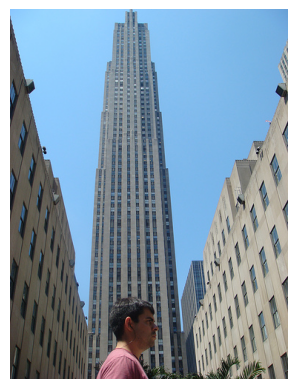

In [18]:
generate_caption("1032460886_4a598ed535.jpg")

In [19]:
model.save(os.path.join(WORKING_DIR, 'caption_model.keras'))


In [20]:
model.save(os.path.join(WORKING_DIR, 'caption_model.h5'))
